# 1 Author
**Student Name**: Jiatong Si  

# 2 Problem formulation
&nbsp;&nbsp;&nbsp;&nbsp;In this project, the input to the model is a 30-second audio clip of a narrative. The objective of the model is to ascertain the veracity of the narrative. In order to achieve this objective, three challenges associated with machine learning must be addressed. First, a training dataset and a test dataset must be constructed. Secondly, a longer audio segment was sampled in order to obtain 30 seconds of audio data, which was then used as input to the model. To ensure the consistency of the sampled data with the original data and to prevent the sampling of a true statement portion of a false storytelling statement (since a storytelling statement may contain both true and false portions), this project considered the sampling of multiple segments of a piece of audio (with the sum of the durations of the segments being 30 seconds) and the use of multiple segments of audio as input. Thirdly, the designed model structure should possess robust feature extraction capabilities. In instances where the input comprises multiple audio segments, the model must also demonstrate proficiency in performing feature fusion. The aforementioned comparison between multiple audio clip input and long audio sampling methods will be further elucidated in the experimental section.

# 3 Methodology
&nbsp;&nbsp;&nbsp;&nbsp;   The objective of this study is to evaluate the performance of single-branch and multi-branch models and to assess the influence of diverse feature extraction techniques on the model's representational capacity. The aim is to identify the most effective model for speech classification. Six datasets were constructed for the purposes of this project. Each dataset employs a k-fold cross-validation scheme, with 80 data points utilized for training and the remaining 20 data points reserved for testing. The hyperparameters of the model will be selected based on the dataset exhibiting the highest average correctness among the 80 training data. The 20 test data points will not be utilized as inputs to the model during the training or hyperparameter selection processes. The evaluation of the model will be based on the performance of the selected hyperparameter set on the 20 test data points. The specific evaluation metrics include accuracy, a confusion matrix, a receiver operating characteristic curve (ROC), precision, recall, and an F1 score.<br>
&nbsp;&nbsp;&nbsp;&nbsp;Before starting the formal training process, the Extractor model's structure is a combination of multi-head attention mechanisms and fully connected hierarchies, with self-attention mechanisms capable of capturing long distance dependencies at any point in the sequence, compared to traditional recurrent neural networks (RNNS) and short term memory networks (LSTMS). Transformer is not limited by sequence length and can capture context information on a global scale, making it more suitable for working with long sequences. This is very important for the extraction of speech features. Because a piece of audio is also a sequence, there is a context relationship between the sequences. If the Extractor can capture the feature relationship, it can get the 30s audio fragment whose feature is closest to the global audio feature, and ensure the integrity of the information as much as possible. Specifically, the training method requires selecting a voice for random masking operations. This requires randomly setting the A[start: start + mask length, :] part of the (l, d) matrix A, obtained from the audio sample by MFCC calculation, to 0. The Extractor input is masked A, and the output result of Extractor is predicted unmasked A^. The loss function is the MSE of predicted A^ and unmasked A. The Adam optimizer is backpropagated to update the Extractor parameters. It is hoped that through the above training, Extractor can gain the ability to capture the context of audio information. This ability is very helpful for extracting audio at 30s.<br>

$$
A = \text{MFCC}(\text{Audio})
$$

$$
A_\text{Predict} = \text{MLP}(\text{MultiHead}(\text{Mask}(A)))
$$

$$
A.shape = (Q, K, V)
$$

$$
A_\text{Predict}.shape = (Q, K, V)
$$


The formulation of Attention calculation:
$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^\top}{\sqrt{d_k}}\right)V
$$

The formulation of Muti-head Attention
$$
\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \text{head}_2, \dots, \text{head}_h)W^O
$$

For each head:

$$
\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)
$$

$$
\text{loss} = \text{MSE}(A_\text{Predict}, A)
$$

# 4 Implemented ML prediction pipelines

&nbsp;&nbsp;&nbsp;&nbsp;In the case of inputting two 15-second speech clips, after transforming the speech into feature vectors, this project employs a multi-branching model structure to extract the features of multiple speech clips and complete the feature fusion. This structure comprises two independent parameterized SVMs and a logistic regression. The SVMs are employed to extract the feature information from individual speech samples, whereas the logistic regression is utilized to synthesize the outputs of the SVMs, thereby generating the final prediction. The inputs to each support vector machine (SVM) model are the features of the audio samples.
In the case of a 30-second speech clip, this project employs the vectors resulting from feature extraction for classification via SVM. The computation of features for the short 30-second audio (or two 15-second audio) obtained using the Extractor from the previous section will be discussed in 4.1, and the details of the model structure will be discussed in 4.2.


# 4.1 Transformation stage
&nbsp;&nbsp;&nbsp;&nbsp;In the case of a 30s audio input, the first step is to load the 30s audio file into memory. The 30s audio signal is then converted into a time series, comprising sample points, and the sampling rate is adjusted according to the requirements of the process. Subsequently, MFCC (Mel Frequency Cepstrum Coefficient) features are extracted from the loaded audio signal. MFCC is a commonly used feature in audio processing, as it can effectively represent the spectral information of the audio. It is commonly used in fields such as speech recognition and music analysis. Another feature extraction method presented in the article is the conversion of the amplitude spectrum of the audio to a decibel scale (dB). This conversion facilitates a more precise approximation of human auditory perception and streamlines the analysis of the audio's dynamic range. By summing the squares of the amplitude spectra of each audio frame, the total energy of that frame is calculated.The two aforementioned feature extraction methods will be compared in the experimental section, and the optimal method for feature extraction will be selected through experimentation for use in the modified audio classification task.



Audio is the input 30s Audio fregment.
For MFCC Method:
$$
\text{Audio\_feature} = \text{MFCC}(\text{Audio})
$$

For feature extraction method using the computational power of vibration spectra:
$$
\text{Audio\_feature} = \text{Energy}(\text{amplitude}(\text{STFT}(\text{Audio})))
$$

# 4.2 Model stage
&nbsp;&nbsp;&nbsp;&nbsp;In this project, a support vector machine (SVM) is selected as the classification model. The SVM identifies an optimal hyperplane in a high-dimensional space, which effectively separates the samples of different classes. Maximizing the classification interval results in enhanced generalization ability. The use of kernel functions (e.g., polynomial kernel, RBF kernel function) enables SVM to identify a nonlinear decision boundary in instances where the input data is nonlinearly differentiable. The task comprises a total of only 100 audio files, which is a relatively small data set. SVM performs well in such cases because it focuses on the support vectors (samples that are close to the decision boundaries) rather than on all the samples. SVM avoids overfitting by controlling the classification intervals in small sample and high-dimensionality cases.<br>
&nbsp;&nbsp;&nbsp;&nbsp;In the case of dividing a 30-second audio file into two 15-second audio files, The precise methodology for splitting the data will be elucidated in greater detail once the dataset has been constructed. In addition to the two parameter-independent SVMs that determine the probability of an audio feature belonging to a true story versus a false story, a model is required that fuses the outputs of the two SVMs to provide the final classification result. In this project, logistic regression is employed as the model that integrates the two SVM outputs to generate the final prediction results. In other words, the positive class probabilities of the SVM outputs will be spliced into a new feature vector, which will then be used as input to the logistic regression model. The logistic regression model is relatively simple, easy to understand, implement, and interpret. It is an extension of the linear model that utilizes probabilistic functions (e.g., sigmoid functions) to map linear combinations to category labels, which is highly intuitive. This task is a binary categorization task, and logistic regression is particularly well suited for binary categorization tasks.<br>
&nbsp;&nbsp;&nbsp;&nbsp;For the case that the 30s audio is not divided into 2 15s audio, the feature vector after MFCC or STFT processing is directly classified by an SVM.<br>

For the case split 30s Audio into two 15s Audios:
$$
\text{Prediction} = \text{LogisticRegression}\left(\text{Concatenate}\left(\text{SVM}_1(\text{Audio\_feature}_1), \text{SVM}_2(\text{Audio\_feature}_2)\right)\right)
$$

For the case not split the 30s input Audio:
$$
\text{Prediction} = \text{SVM}(\text{Audio\_feature})
$$


In [1]:
import os
import librosa
import IPython.display as ipd
import numpy as np
import pandas as pd
import soundfile as sf
import time
from tqdm import tqdm
from IPython.display import Audio
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from typing import Tuple
import shutil
from joblib import Parallel, delayed
from sklearn.svm import SVC
import heapq
from sklearn.linear_model import LogisticRegression
from decimal import Decimal, getcontext
from scipy.spatial.distance import euclidean
import torch
from torch import nn, einsum
from einops import rearrange, repeat
import random
from einops.layers.torch import Rearrange
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score

## Hyperparameters

In [54]:
sample_type = 'mfcc'  # mfcc, energy
time_interval, num, hop_length = 30., 1, 512
norm = True
noise = True
fs = None
fold_num = 5
use_transformer = True
if use_transformer:
    dim, head_num = 12, 2
else:
    dim = 13
path_csv = 'MLEnd/deception/MLEndDD_story_attributes_small.csv'
path_data = 'MLEnd/deception/MLEndDD_stories_small'
cases = sorted(os.listdir(path_data))
print(f'The total cases number is {len(cases)}.')
df = pd.read_csv(path_csv)
if sample_type == 'energy' and use_transformer:
    raise ValueError('Transformer only supports mfcc sample type!!')

The total cases number is 100.


In [60]:
sample_types = ['mfcc', 'energy']
nums = [1, 2]
use_transformers = [False, True]

## Defined functions and classes

In [57]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class Attention(nn.Module):
    def __init__(self, dim, heads=2, dim_head=6, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim=-1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout),
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=h), qkv)

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = self.attend(dots)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)


class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout))
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class Extractor(nn.Module):
    def __init__(self, dim, out_dim, depth, heads, mlp_dim, pool='cls', dim_head=6, dropout=0., emb_dropout=0.):
        super().__init__()
        assert pool in {'cls', 'mean'}

        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, out_dim)
        )

    def forward(self, x): 
        x = x.unsqueeze(0)
        x = x.permute(0, 2, 1)
        b, n, _ = x.shape
        x = self.dropout(x)
        x = self.transformer(x)
        x = self.to_latent(x)
        return self.mlp_head(x)

def random_mask(x, mask_ratio):
    if not (0.0 <= mask_ratio <= 1.0):
        raise ValueError("mask_ratio must be between 0.0 and 1.0")
    
    l = x.shape[-1]
    masked_l = min(int(l * mask_ratio), l - 1) 

    if masked_l <= 0:
        raise ValueError("masked_l must be greater than 0. Reduce mask_ratio or increase sequence length.")
    start = random.randint(0, max(l - masked_l - 1, 0))

    masked_x = x.clone()
    masked_x[:, start: start + masked_l] = 0.
    return masked_x, start

def diff_cumputer(audio, global_mfcc, global_mean, global_std, sr, n_mfcc) -> float:
    segment_mfcc = extract_mfcc(audio, sr, n_mfcc)
    segment_mean = np.mean(segment_mfcc, axis=1)
    segment_std = np.std(segment_mfcc, axis=1)
    distance = euclidean(global_mean, segment_mean) + euclidean(global_std, segment_std)
    return distance
    
def extract_mfcc(audio, sr, n_mfcc=13):
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    return mfcc

def find_similar_segment_mfcc(audio, sr, time_interval, num, n_mfcc=dim) -> list:
    global_mfcc = extract_mfcc(audio, sr, n_mfcc)
    global_mean = np.mean(global_mfcc, axis=1)
    global_std = np.std(global_mfcc, axis=1)
    
    per_interval = int(time_interval / num)
    window_size = int(per_interval * sr)
    result = [[float('-inf'), [float('-inf'), float('-inf')]]] * num
    heapq.heapify(result)
    start, flag = 0, 0
    stride = int(window_size / 2.)
    while start < len(audio) - window_size:
        if flag < num:
            segment = audio[start: start + window_size]
            distance = diff_cumputer(segment, global_mfcc, global_mean, global_std, fs, n_mfcc)
            temp = [-distance, [start, start + window_size]]
            
            heapq.heappop(result)
            heapq.heappush(result, temp)

            start += stride
            flag += 1
        else:
            segment = audio[start: start + window_size]
            distance = diff_cumputer(segment, global_mfcc, global_mean, global_std, fs, n_mfcc)
            temp = [-distance, [start, start + window_size]]
            if -result[0][0] > -temp[0]:
                heapq.heappop(result)
                heapq.heappush(result, temp)
            start += stride
    return result

def find_similar_segment_energy(frame_energies, time_interval, num, sr, hop_length=512) -> list:
    result = [[float('-inf'), [float('-inf'), float('-inf')]]] * num
    heapq.heapify(result)
    
    time_per_interval = int(time_interval / num)
    window_size = int(time_per_interval * sr / hop_length)
    start, end_start = 0, len(frame_energies) - window_size
    flag = 0
    stride = int(window_size / 2)
    
    while start < end_start:
        if flag < num:
            energy = sum(frame_energies[start: start + window_size])
            heapq.heappop(result)
            heapq.heappush(result, [energy, [start, start + window_size]])
            start += stride
            flag += 1
        else:
            energy = sum(frame_energies[start: start + window_size])
            if energy > result[0][0]:
                heapq.heappop(result)
                heapq.heappush(result, [energy, [start, start + window_size]])               
            start += stride
    return result

def process_case(case, path_cases, df, sample_type):
    filename = case + '.wav'
    if df[df.iloc[:, 0] == filename].iloc[0, 2] == 'true_story':
        label = 1.
    else:
        label = -1.

    features = []

    case_segments= sorted(os.listdir(os.path.join(path_cases, case)))
    
    for case_segment in case_segments:
        x, sr = librosa.load(os.path.join(path_cases, case, case_segment), sr=None)
        if sample_type == 'mfcc':
            x_mfcc = extract_mfcc(x, sr, 13)
            x_mean = np.mean(x_mfcc, axis=1)
            x_std = np.std(x_mfcc, axis=1)
            feature = np.concatenate([x_mean, x_std], axis=0)
        elif sample_type == 'energy':
            f0, voiced_flag, voiced_probs = librosa.pyin(x, fmin=librosa.note_to_hz('C1'), fmax=librosa.note_to_hz('C8'))
            frame_energies = np.sum(np.abs(librosa.stft(x))**2, axis=0)
            feature = [np.nanmean(f0), np.nanstd(f0), np.nanmean(frame_energies), np.nanstd(frame_energies)]
        features.append(feature)
    return features, label

def loader(df, sample_type, num, use_transformer) -> Tuple[np.array, np.array]:
    print(f'Loading data...')
    if not use_transformer:
        path_cases = 'MLEnd/deception/multi_segment_samples_' + sample_type + str(num)
    else:
        path_cases = 'MLEnd/deception/multi_segment_samples_' + sample_type + '_transformer' + str(num)
    cases = sorted(os.listdir(path_cases))
    results = Parallel(n_jobs=10)(delayed(process_case)(case, path_cases, df, sample_type) for case in tqdm(cases))
    X = [result[0] for result in results]
    Y = [result[1] for result in results]
    X, Y = np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32)
    print(f'Data loading finish...')
    if not use_transformer:
        np.save('all_data_' + sample_type + str(num) + '.npy', X)
    else:
        np.save('all_data_' + sample_type + '_transformer' + str(num), X)
        
    if not os.path.exists('all_labels.npy'):
        np.save('all_labels.npy', Y)
    return X, Y

def find_similar_segment_mfcc_transformer(audio, sr, time_interval, num, extractor, n_mfcc=dim) -> list:
    global_mfcc = extract_mfcc(audio, sr, n_mfcc)
    global_feature = extractor(torch.tensor(global_mfcc))
    global_feature = torch.mean(global_feature, 1)
    per_interval = int(time_interval / num)
    window_size = int(per_interval * sr)
    result = [[float('-inf'), [float('-inf'), float('-inf')]]] * num
    heapq.heapify(result)
    start, flag = 0, 0
    stride = int(window_size / 2.)
    while start < len(audio) - window_size:
        if flag < num:
            segment = audio[start: start + window_size]
            distance = diff_cumputer_transformer(segment, global_feature, fs, n_mfcc, extractor)
            temp = [-distance, [start, start + window_size]]
            
            heapq.heappop(result)
            heapq.heappush(result, temp)

            start += stride
            flag += 1
        else:
            segment = audio[start: start + window_size]
            distance = diff_cumputer_transformer(segment, global_feature, fs, n_mfcc, extractor)
            temp = [-distance, [start, start + window_size]]
            if -result[0][0] > -temp[0]:
                heapq.heappop(result)
                heapq.heappush(result, temp)
            start += stride
    return result

def diff_cumputer_transformer(audio, global_feature, sr, n_mfcc, extractor) -> float:
    segment_mfcc = extract_mfcc(audio, sr, n_mfcc)
    segment_feature = torch.mean(extractor(torch.tensor(segment_mfcc)), 1)
    distance = torch.sqrt(torch.sum((global_feature - segment_feature) ** 2))
    return distance

## Pre-training of Transformer(Extractor)

In [17]:
if use_transformer:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    extractor = Extractor(dim=dim, out_dim=dim, depth=1, heads=head_num, mlp_dim=6).to(device)
    losses = []
    for epoch in range(25):
        total_loss = 0
        count = 0
        for i in tqdm(range(100)):
            x, fs = librosa.load(os.path.join(path_data, cases[i]),sr=fs)
            x = librosa.feature.mfcc(y=x, sr=fs, n_mfcc=dim)  
            start = 0
            interval = int(30 * fs / 512)
            while start < x.shape[-1] - interval:
                count += 1
                x = x[:, start: start + interval]
                x = torch.tensor(x).to(device)   
                masked_x, start = random_mask(x, 0.2)
                x = x.unsqueeze(0)   
                
                optimizer = torch.optim.Adam(extractor.parameters(), lr=1e-3)
                
                predicted = extractor(masked_x.to(device))
                predicted = predicted.permute(0, 2, 1)
                
                loss = torch.mean((predicted - x) ** 2)
                
                loss.backward()
                optimizer.step()
                start += interval
                total_loss += loss.item()
        losses.append(total_loss / count)
        print(f'Average loss of epoch {epoch + 1}: {total_loss / count:.2f}.')
    torch.save(extractor.state_dict(), "model_params.pth")

100%|█████████████████████████████████████████| 100/100 [00:22<00:00,  4.44it/s]


Average loss of epoch 1: 21564.17.


100%|█████████████████████████████████████████| 100/100 [00:22<00:00,  4.40it/s]


Average loss of epoch 2: 21444.19.


100%|█████████████████████████████████████████| 100/100 [00:22<00:00,  4.36it/s]


Average loss of epoch 3: 21302.73.


100%|█████████████████████████████████████████| 100/100 [00:23<00:00,  4.29it/s]


Average loss of epoch 4: 21127.37.


100%|█████████████████████████████████████████| 100/100 [00:23<00:00,  4.29it/s]


Average loss of epoch 5: 20905.63.


100%|█████████████████████████████████████████| 100/100 [00:23<00:00,  4.21it/s]


Average loss of epoch 6: 20603.78.


100%|█████████████████████████████████████████| 100/100 [00:23<00:00,  4.25it/s]


Average loss of epoch 7: 20210.45.


100%|█████████████████████████████████████████| 100/100 [00:24<00:00,  4.17it/s]


Average loss of epoch 8: 19732.27.


100%|█████████████████████████████████████████| 100/100 [00:23<00:00,  4.26it/s]


Average loss of epoch 9: 19206.89.


100%|█████████████████████████████████████████| 100/100 [00:23<00:00,  4.23it/s]


Average loss of epoch 10: 18663.66.


100%|█████████████████████████████████████████| 100/100 [00:24<00:00,  4.10it/s]


Average loss of epoch 11: 18119.23.


100%|█████████████████████████████████████████| 100/100 [00:24<00:00,  4.11it/s]


Average loss of epoch 12: 17573.72.


100%|█████████████████████████████████████████| 100/100 [00:24<00:00,  4.12it/s]


Average loss of epoch 13: 17018.55.


100%|█████████████████████████████████████████| 100/100 [00:24<00:00,  4.11it/s]


Average loss of epoch 14: 16454.86.


100%|█████████████████████████████████████████| 100/100 [00:24<00:00,  4.14it/s]


Average loss of epoch 15: 15878.39.


100%|█████████████████████████████████████████| 100/100 [00:23<00:00,  4.18it/s]


Average loss of epoch 16: 15278.88.


100%|█████████████████████████████████████████| 100/100 [00:24<00:00,  4.16it/s]


Average loss of epoch 17: 14662.52.


100%|█████████████████████████████████████████| 100/100 [00:24<00:00,  4.05it/s]


Average loss of epoch 18: 14023.76.


100%|█████████████████████████████████████████| 100/100 [00:24<00:00,  4.17it/s]


Average loss of epoch 19: 13393.68.


100%|█████████████████████████████████████████| 100/100 [00:24<00:00,  4.08it/s]


Average loss of epoch 20: 12770.89.


100%|█████████████████████████████████████████| 100/100 [00:23<00:00,  4.17it/s]


Average loss of epoch 21: 12140.15.


100%|█████████████████████████████████████████| 100/100 [00:24<00:00,  4.11it/s]


Average loss of epoch 22: 11518.16.


100%|█████████████████████████████████████████| 100/100 [00:24<00:00,  4.07it/s]


Average loss of epoch 23: 10925.43.


100%|█████████████████████████████████████████| 100/100 [00:25<00:00,  4.00it/s]


Average loss of epoch 24: 10365.03.


100%|█████████████████████████████████████████| 100/100 [00:24<00:00,  4.13it/s]

Average loss of epoch 25: 9848.11.


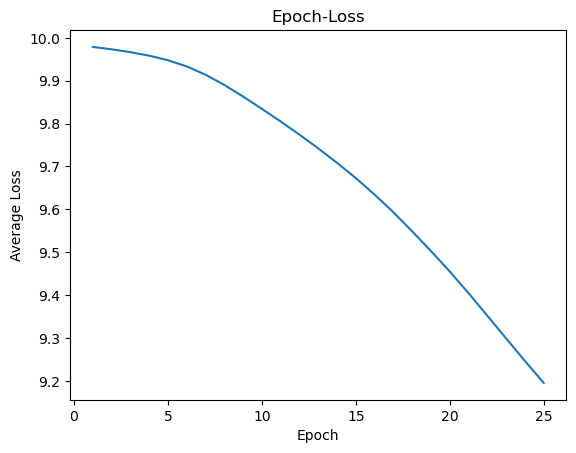

In [22]:
plt.figure()
plt.plot(np.arange(25) + 1, np.log(np.array(losses)))
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Epoch-Loss')
plt.show()
plt.close()

Because of the limitation of computing power and time, the number of Extractor parameters is very small, the training cycle is also very short, and the loss does not converge. It is hoped that the sequence feature extraction ability of Extractor can be further improved after the improvement of computing power in the future.

In [27]:
if use_transformer:
    device = 'cpu'
    extractor = Extractor(dim=dim, out_dim=dim, depth=1, heads=head_num, mlp_dim=12).to(device)
    #extractor.load_state_dict(torch.load("model_params.pth"))
    print('Transformer already loaded!!')
    extractor.eval()

Transformer already loaded!!


## An example of Segment a 30s Audio

Sampled by mfcc with transformer, totally 1 samples:
The start of this signal is 45.0s and the end of this signal is 75.0s.


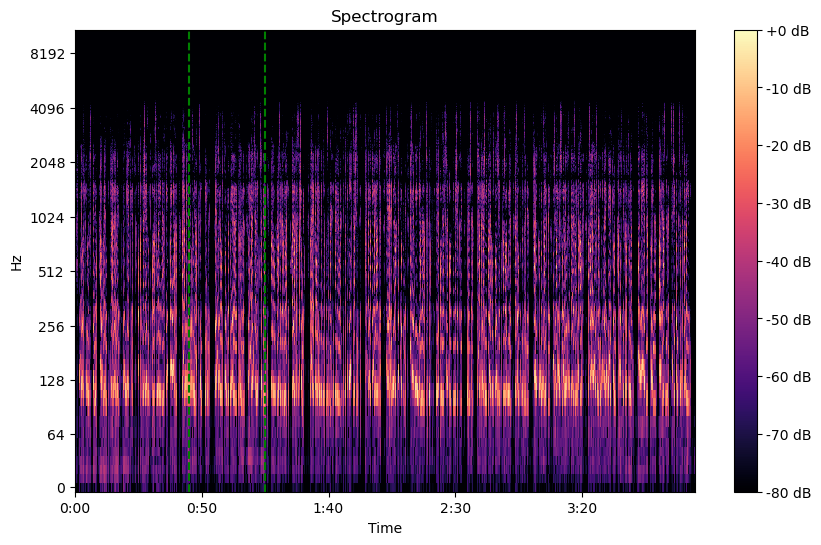

In [28]:
x, fs = librosa.load(os.path.join(path_data, cases[0]),sr=fs)
D = librosa.stft(x)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
frame_energies = np.sum(np.abs(D)**2, axis=0)

if sample_type == 'mfcc' and not use_transformer:
    samples = find_similar_segment_mfcc(x, fs, time_interval, num, n_mfcc=dim)
elif sample_type == 'mfcc' and use_transformer:
    samples = find_similar_segment_mfcc_transformer(x, fs, time_interval, num, extractor)
elif sample_type == 'energy':
    samples = find_similar_segment_energy(frame_energies, time_interval, num, fs)
else:
    raise ValueError('sample_type invalid!!')

if not use_transformer:
    print(f'Sampled by {sample_type} without transformer, totally {len(samples)} samples:')
else:
    print(f'Sampled by {sample_type} with transformer, totally {len(samples)} samples:')

plt.figure(figsize=(10, 6))
librosa.display.specshow(S_db, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
if sample_type == 'mfcc' and not use_transformer:
    for sample in samples:
        print(f'The start of this signal is {sample[1][0] / fs}s and the end of this signal is {sample[1][1] / fs}s.')
        plt.axvline(sample[1][0] / fs, color='green', linestyle='--') 
        plt.axvline(sample[1][1] / fs, color='green', linestyle='--')    
elif sample_type == 'mfcc' and use_transformer:
    for sample in samples:
        print(f'The start of this signal is {sample[1][0] / fs}s and the end of this signal is {sample[1][1] / fs}s.')
        plt.axvline(sample[1][0] / fs, color='green', linestyle='--') 
        plt.axvline(sample[1][1] / fs, color='green', linestyle='--')
elif sample_type == 'energy':
    for sample in samples:
        print(f'The start of this signal is {sample[1][0] * hop_length/ fs}s and the end of this signal is {sample[1][1] * hop_length / fs}s.')
        plt.axvline(sample[1][0] * hop_length / fs, color='green', linestyle='--') 
        plt.axvline(sample[1][1] * hop_length / fs, color='green', linestyle='--') 
plt.show()

# 5 Dataset
&nbsp;&nbsp;&nbsp;&nbsp;The original dataset utilized for this task is the MLEnd Deception Dataset. In order to successfully complete the classification task, it is first necessary to extract the long audio from the original dataset and transform it into a 30-second audio segment whose features are most similar to those of the original audio. This project proposes three extraction methods, which will be compared in the experimental section so that the optimal extraction method can be selected. The initial approach involves the utilisation of the previously mentioned pre-trained Extractor. Initially, the feature vector of the entire feature matrix of the original audio, subsequent to the original audio being computed by MFCC through the Extractor, is computed as the global feature vector. Subsequently, a sliding window of 30 seconds is employed on the feature matrix derived from the original audio after it has been computed by MFCC. The feature vector of the features within the window is then computed by the Extractor, and the Euclidean distance between this feature vector and the global feature vector is calculated. The closer the distance is to zero, the closer the features within the window are to the global features. The proximity of the distance indicates the degree of similarity between the local and global features. The audio segment with the shortest Euclidean distance is selected as the extracted 30-second audio clip.<br>
&nbsp;&nbsp;&nbsp;&nbsp;The second method entails the direct calculation of the mean and standard deviation of the entire audio sequence, computed by MFCC, as the two global features, rather than utilizing the Extractor to extract features. The mean and standard deviation of the sequence within the 30-second sliding window are calculated, and the sum of the Euclidean distances between the mean of the global sequence and the mean of the sequence within the sliding window, as well as between the standard deviation of the global sequence and the standard deviation of the sequence within the sliding window, is employed as a measure of the feature difference. A smaller value indicates a narrower feature gap. The audio sequence corresponding to the 30-second window with the smallest feature gap is selected as the extracted audio.<br>
&nbsp;&nbsp;&nbsp;&nbsp;The third method entails the utilization of STFT to transform the audio into the frequency domain, subsequently converting the amplitude to a decibel spectrum. Thereafter, the energy of each frame is calculated, and the audio corresponding to the 30-second window with the greatest energy is selected as the audio after extraction.<br>
&nbsp;&nbsp;&nbsp;&nbsp;The aforementioned models for extracting a 30-second audio segment using a single 30-second sliding window are analogous to the previous model, which employed a single SVM for direct classification.<br>
&nbsp;&nbsp;&nbsp;&nbsp;This project also investigates the impact of the number of windows on the classification outcomes when extracting long audio features. If two windows are selected for extraction, that is, each window extracts the two audio segments with the smallest gap between 15s and global features or the largest energy as the extraction result, respectively. This approach aligns with the previous approach of slicing 30s audio into two 15s segments, followed by two SVMs with one logistic regression.<br>
&nbsp;&nbsp;&nbsp;&nbsp;The complete dataset assembled via the aforementioned methodology will be randomly selected for k-fold cross-validation on 80 data points to identify the optimal hyperparameters, after which this set of hyperparameters will be employed to assess the model's performance on the remaining 20 data points. Notably, these 20 data points were not presented to the model during the hyperparameter selection process.<br>
&nbsp;&nbsp;&nbsp;&nbsp;Due to the need to compare the performance of eight models and the limitation of computing power, each code run takes a long time. In order to save the time of multiple runs, the database built by multiple methods is kept locally, which is easy to read directly during the next run.<br>

********Finding optimal hyperparameter at mfcc with 1 window(s) not with Extractor ********
Already sampled!!!
Data loaded!
Now the max acc is 51.00%
Now the max acc is 54.00%
Now the max acc is 55.00%
Now the max acc is 56.00%
Now the max acc is 57.00%
Now the max acc is 58.00%
Now the max acc is 59.00%
Now the max acc is 59.00%
Now the max acc is 61.00%


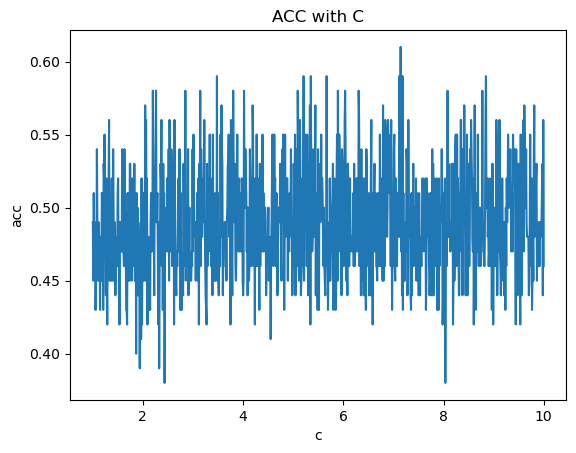

********Finding optimal hyperparameter at mfcc with 1 window(s) with Extractor ********
Already sampled!!!
Data loaded!
Now the max acc is 55.00%
Now the max acc is 57.00%
Now the max acc is 58.00%
Now the max acc is 59.00%
Now the max acc is 60.00%
Now the max acc is 62.00%


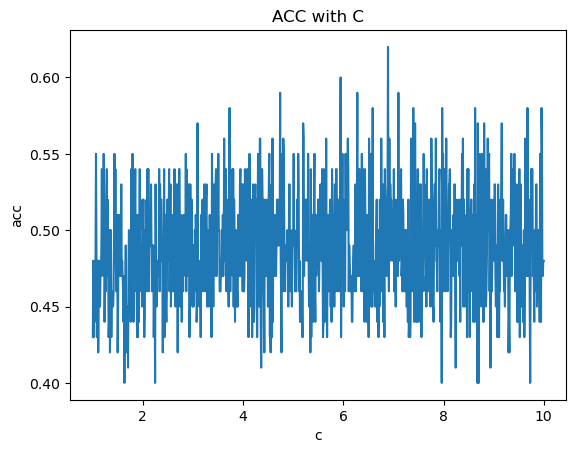

********Finding optimal hyperparameter at mfcc with 2 window(s) not with Extractor ********
Already sampled!!!
Data loaded!
Now the max acc is 54.00%
Now the max acc is 56.00%
Now the max acc is 57.00%


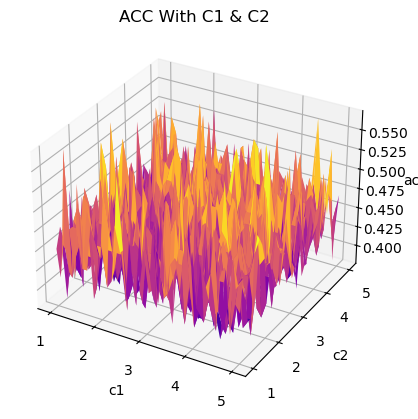

********Finding optimal hyperparameter at mfcc with 2 window(s) with Extractor ********
Already sampled!!!
Data loaded!
Now the max acc is 52.00%
Now the max acc is 52.00%
Now the max acc is 53.00%
Now the max acc is 54.00%
Now the max acc is 58.00%
Now the max acc is 59.00%


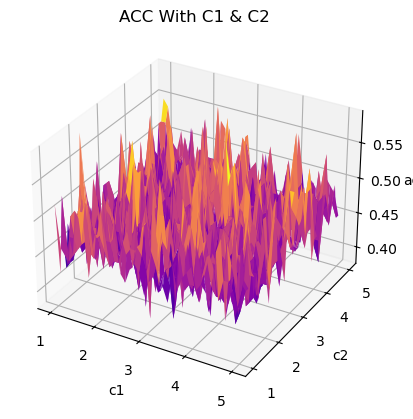

********Finding optimal hyperparameter at energy with 1 window(s) not with Extractor ********
Already sampled!!!
Data loaded!
Now the max acc is 50.00%
Now the max acc is 51.00%
Now the max acc is 52.00%
Now the max acc is 54.00%
Now the max acc is 54.00%
Now the max acc is 55.00%
Now the max acc is 57.00%
Now the max acc is 58.00%
Now the max acc is 61.00%


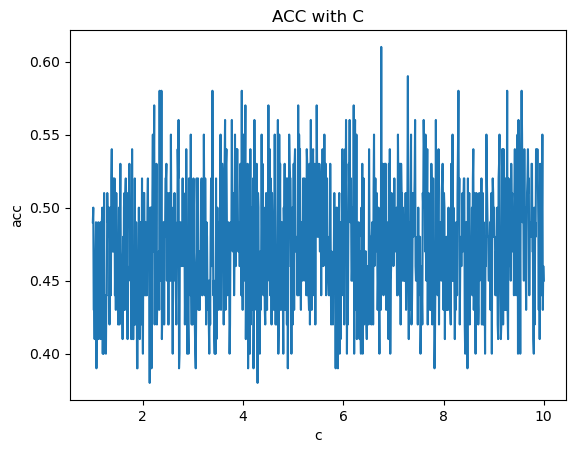

********Finding optimal hyperparameter at energy with 1 window(s) with Extractor ********
Already sampled!!!
Data loaded!
Now the max acc is 52.00%
Now the max acc is 54.00%
Now the max acc is 56.00%
Now the max acc is 57.00%
Now the max acc is 59.00%
Now the max acc is 61.00%
Now the max acc is 61.00%


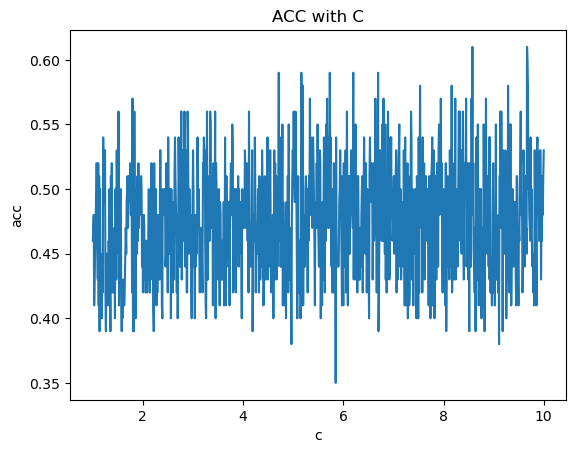

********Finding optimal hyperparameter at energy with 2 window(s) not with Extractor ********
Already sampled!!!
Data loaded!
Now the max acc is 52.00%
Now the max acc is 55.00%
Now the max acc is 58.00%


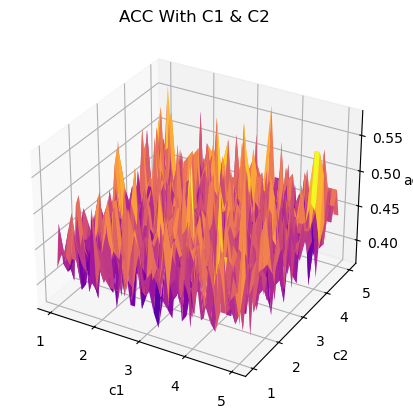

********Finding optimal hyperparameter at energy with 2 window(s) with Extractor ********
Already sampled!!!
Data loaded!
Now the max acc is 56.00%
Now the max acc is 56.00%


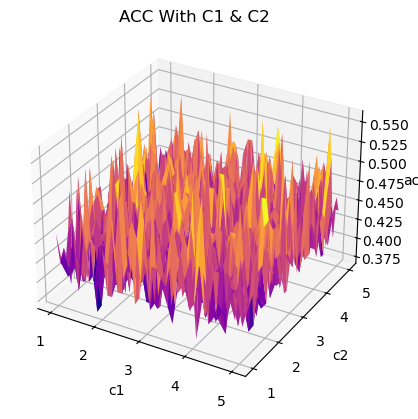

In [63]:
for sample_type in sample_types:
    for num in nums:
        for use_transformer in use_transformers:
            if not use_transformer:
                print('*' * 8 + f'Finding optimal hyperparameter at {sample_type} with {num} window(s) not with Extractor', '*' * 8)
            else:
                print('*' * 8 + f'Finding optimal hyperparameter at {sample_type} with {num} window(s) with Extractor', '*' * 8)
            if sample_type == 'mfcc' and not use_transformer:
                new_data_path = 'MLEnd/deception/multi_segment_samples_mfcc' + str(num)
            elif sample_type == 'mfcc' and use_transformer:
                new_data_path = 'MLEnd/deception/multi_segment_samples_mfcc_transformer' + str(num)
            elif sample_type == 'energy':
                new_data_path = 'MLEnd/deception/multi_segment_samples_energy' + str(num)
            if not os.path.exists(new_data_path):
                os.mkdir(new_data_path)
                print('*' * 25 + 'Start sampling radio signals' + '*' * 25)
            
                for case in cases:
                    fs = None
                    path_case = os.path.join(path_data, case)
                    x, fs = librosa.load(path_case,sr=fs)
                    if sample_type == 'mfcc' and not use_transformer:
                        samples = find_similar_segment_mfcc(x, fs, time_interval, num, n_mfcc=dim)
                    elif sample_type == 'mfcc' and use_transformer:
                        samples = find_similar_segment_mfcc_transformer(x, fs, time_interval, num, extractor)
                    elif sample_type == 'energy':
                        samples = find_similar_segment_energy(frame_energies, time_interval, num, fs)
                    path_segments = os.path.join(new_data_path, case[:-4])
                    os.mkdir(path_segments)
                    
                    count_sample = 0
                    for sample in samples:
                        if sample_type == 'energy':
                            x_cut_temp = x[sample[1][0] * hop_length: (sample[1][1] + 1) * hop_length]
                        elif sample_type == 'mfcc':
                            x_cut_temp = x[sample[1][0]: sample[1][1]]
                        sf.write(os.path.join(path_segments, str(count_sample).zfill(2) + '.wav'), x_cut_temp, fs)
                        count_sample += 1
                    
                print('*' * 25 + 'Already sampled' + '*' * 25)
            else:
                    print('Already sampled!!!')
    
            if sample_type == 'mfcc' and not use_transformer:
                path_all_data, path_all_labels = 'all_data_mfcc' + str(num) + '.npy', 'all_labels.npy'
            elif sample_type == 'mfcc' and use_transformer:
                path_all_data, path_all_labels = 'all_data_mfcc_transformer' + str(num) + '.npy', 'all_labels.npy'
            elif sample_type == 'energy':
                path_all_data, path_all_labels = 'all_data_energy' + str(num) + '.npy', 'all_labels.npy'
            else:
                raise ValueError('sample_type invalid!')
            
            if os.path.exists(path_all_data) and os.path.exists(path_all_labels):
                all_data, all_labels = np.load(path_all_data), np.load(path_all_labels)
            else:
                print(f'The first time loading {sample_type} data of {num} segments...')
                all_data, all_labels = loader(df, sample_type, num, use_transformer)
            
            all_data = np.nan_to_num(all_data, nan=0)
            print('Data loaded!')
            
            if len(cases) % fold_num != 0:
                raise ValueError('Fold must be a factor of 100!!!')
                
            total_data, total_labels = [], []
            for i in range(fold_num):
                seg_data = all_data[i * int(len(cases) / fold_num): (i + 1) * int(len(cases) / fold_num)]
                seg_label = all_labels[i * int(len(cases) / fold_num): (i + 1) * int(len(cases) / fold_num)]
                total_data.append(seg_data)
                total_labels.append(seg_label)
            if num == 1:
                cs = np.linspace(1, 10, 1000)
                accs = []
                max_acc = 0.50
                for c in cs:
                    avg_acc = 0.
                    for k in range(fold_num):
                        valid_data, valid_label = total_data.pop(0), total_labels.pop(0)
                        train_data, train_label = np.concatenate(total_data, axis=0), np.concatenate(total_labels, axis=0)  # 80, 1, 4
                        if norm:
                            mean_train, std_train = train_data.mean(), train_data.std() 
                            norm_train_data = (train_data - mean_train) / std_train
                            norm_valid_data = (valid_data - mean_train) / std_train
                        elif not norm:
                            norm_train_data = train_data
                            norm_valid_data = valid_data
            
                        if noise:
                            train_noise = np.random.randn(train_data.shape[0], train_data.shape[1], train_data.shape[2])
                            norm_noise_train_data = norm_train_data + train_noise
                        elif not noise:
                            norm_noise_train_data = norm_train_data
            
                        model = SVC(C=c, kernel='rbf', gamma='scale', probability=True)
                        model.fit(norm_noise_train_data[:, 0], train_label)
                            
                        y_v_p_1 = model.predict(norm_valid_data[:, 0])
                        avg_acc += np.mean(y_v_p_1==valid_label)
            
                        total_data.append(valid_data)
                        total_labels.append(valid_label)
                        
                    avg_acc /= fold_num
                    accs.append(avg_acc)
                    if avg_acc > max_acc:
                        max_acc = avg_acc
                        print(f'Now the max acc is {(max_acc * 100):.2f}%')
                        with open('hyperparam_' + sample_type + '_' + str(num) + '_.txt', "w") as file:
                            file.write(f"a = {c}\n")
                            file.write(f"max_acc = {max_acc}\n")
                plt.figure()
                plt.plot(cs, np.array(accs))
                plt.title(f'ACC with C')
                plt.xlabel('c')
                plt.ylabel('acc')
                plt.show()
                plt.close()      
            elif num == 2:
                c1s = np.linspace(1, 5, 40)
                c2s = np.linspace(1, 5, 40)
                accs = []
                max_acc = 0.50
                for c1 in c1s:
                    temp = []
                    for c2 in c2s:
                        avg_acc = 0.
                        for k in range(fold_num):
                            valid_data, valid_label = total_data.pop(0), total_labels.pop(0)
                            train_data, train_label = np.concatenate(total_data, axis=0), np.concatenate(total_labels, axis=0)
                
                            if norm:
                                mean_train, std_train = train_data.mean(), train_data.std() 
                                norm_train_data = (train_data - mean_train) / std_train
                                norm_valid_data = (valid_data - mean_train) / std_train
                            elif not norm:
                                norm_train_data = train_data
                                norm_valid_data = valid_data
                
                            if noise:
                                train_noise = np.random.randn(train_data.shape[0], train_data.shape[1], train_data.shape[2])
                                norm_noise_train_data = norm_train_data + train_noise
                            elif not noise:
                                norm_noise_train_data = norm_train_data
                
                            model_1 = SVC(C=c1, kernel='rbf', gamma='scale', probability=True)
                            model_2 = SVC(C=c2, kernel='rbf', gamma='scale', probability=True)
                
                            model_1.fit(norm_noise_train_data[:, 0], train_label)
                            model_2.fit(norm_noise_train_data[:, 1], train_label)
                            
                            y_p_1 = model_1.predict_proba(norm_noise_train_data[:, 0])
                            y_p_2 = model_2.predict_proba(norm_noise_train_data[:, 1])
                            x_3 = np.stack((y_p_1[:, 1], y_p_2[:, 1]), axis=-1)
                    
                            model_3 = LogisticRegression()
                            model_3.fit(x_3, train_label)
                            
                            y_p_3 = model_3.predict(x_3)
                    
                            y_v_p_1 = model_1.predict_proba(norm_valid_data[:, 0])
                            y_v_p_2 = model_2.predict_proba(norm_valid_data[:, 1])
                            x_v_3 = np.stack((y_v_p_1[:, 1], y_v_p_2[:, 1]), axis=-1)
                            y_v_p_3 = model_3.predict(x_v_3)
                            avg_acc += np.mean(y_v_p_3==valid_label)
                
                            total_data.append(valid_data)
                            total_labels.append(valid_label)
                        avg_acc /= fold_num
                        temp.append(avg_acc)
                        
                        if avg_acc > max_acc:
                            max_acc = avg_acc
                            print(f'Now the max acc is {(max_acc * 100):.2f}%')
                            
                            with open('hyperparam_' + sample_type + '_' + str(num) + '_.txt', "w") as file:
                                file.write(f"a = {c1}\n")
                                file.write(f"b = {c2}\n")
                                file.write(f"max_acc = {max_acc}\n")
                    accs.append(temp)
                
                accs = np.array(accs)
                c1s, c2s = np.meshgrid(c1s, c2s)
                
                fig = plt.figure()
                ax = fig.add_subplot(111, projection='3d') 
                
                ax.plot_surface(c1s, c2s, accs, cmap='plasma') 
                
                ax.set_title("ACC With C1 & C2")
                ax.set_xlabel("c1")
                ax.set_ylabel("c2")
                ax.set_zlabel("acc")
                
                plt.show()
                plt.close()

Above block shows the process of chosing optimal hyperparameters.

# 6 Experiments and results
&nbsp;&nbsp;&nbsp;&nbsp;The experimental section examines four methods for shortening long audio files into 30-second segments. The first method employs the use of Mel-frequency cepstral coefficients (MFCC) to calculate a feature sequence. The second method utilizes the Euclidean distance to identify the segment exhibiting the greatest similarity between the local and global features. The MFCC is employed to obtain the feature sequence, which is then extracted by the Extractor tool to identify the global features. Subsequently, the Euclidean distance is calculated, and the segment exhibiting the closest proximity to the global features is identified. The energy is calculated using SFTP and a vibration spectrum, with the objective of selecting the segment exhibiting the highest energy as the input to the model. The combination of SFTP and vibration spectrum with Extractor is employed to extract global features, which are then identified as the segment with the closest Euclidean distance to the global feature.<br>
&nbsp;&nbsp;&nbsp;&nbsp;The aforementioned four methods of intercepting long audio into 30-second segments correspond to a sliding window of length one, whereby the model input is a 30-second audio segment that will not be segmented. The sliding window length is two, whereby the model input is a 30-second audio segment split into two 15-second segments. Two sampling methods are employed.<br>
&nbsp;&nbsp;&nbsp;&nbsp;Consequently, the experimental phase of the study compares all eight sampling methods.<br>
&nbsp;&nbsp;&nbsp;&nbsp;A review of the resulting data indicates that the Energy + 1 window + Extractor approach exhibits the highest ACC, while the MFCC + 2 window approach demonstrates the highest precision. Additionally, the majority of positive class predictions made by the model are accurate. The Energy + 2 window, MFCC + 2 window, MFCC + 1 Energy + 2 window, MFCC + 2 window, and MFCC + 1 Energy + 2 window all demonstrate comparable performance. The recall for the one-window and MFCC + 1 window + Energy approaches is nearly 1, indicating that the model is highly accurate in identifying positive class samples. The method of MFCC + 1 window + Energy has the highest F1-score, demonstrating the model's ability to accurately predict positive class samples while also covering a significant proportion of them.<br>
&nbsp;&nbsp;&nbsp;&nbsp;Nevertheless, it is evident that none of the aforementioned eight methods exhibit optimal performance, as evidenced by the lack of convexity observed in their respective ROC curves. Additionally, the recall rate is comparatively elevated, while the F1-score remains relatively low. The model demonstrates a high degree of accuracy in recognizing positive class samples, with minimal underreporting. However, this does not necessarily indicate that the model performs well overall. The model predicts a considerable number of positive samples, yet the majority of these are false positives. The AUC value is close to 0.5, indicating that the model's overall discriminative ability is poor. Its capacity to distinguish between positive and negative samples is nearly equivalent to random guessing.<br>

********Experiment of mfcc with 1 window(s) not with Extractor ********
The avg_acc of mfcc: 55.00%
The avg_precision of mfcc: 0.60
The avg_recall of mfcc: 0.69
The avg_f1_score of mfcc: 0.49


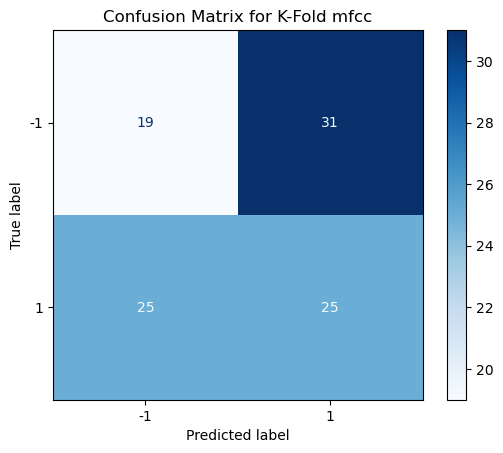

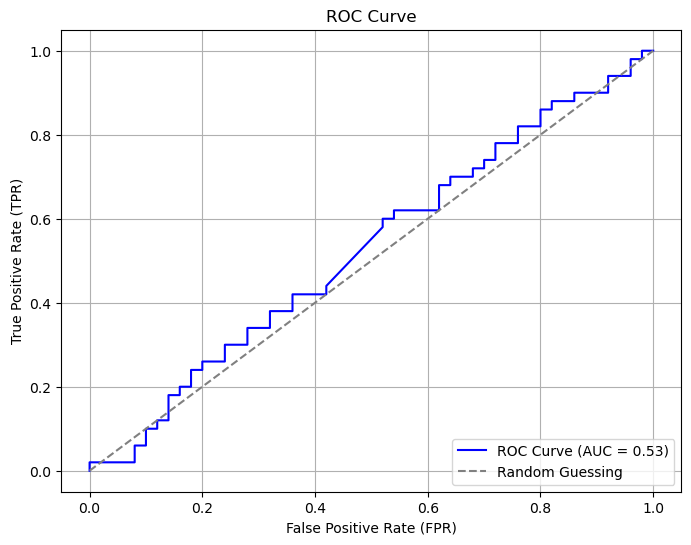

********Experiment of mfcc with 1 window(s) not with Extractor over! ********
********Experiment of mfcc with 1 window(s) with Extractor ********
The avg_acc of mfcc: 61.25%
The avg_precision of mfcc: 0.61
The avg_recall of mfcc: 1.04
The avg_f1_score of mfcc: 0.76


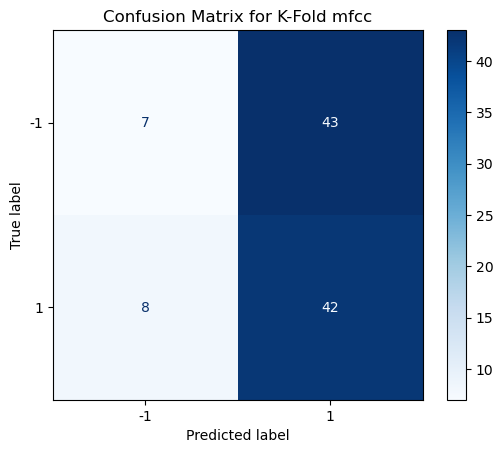

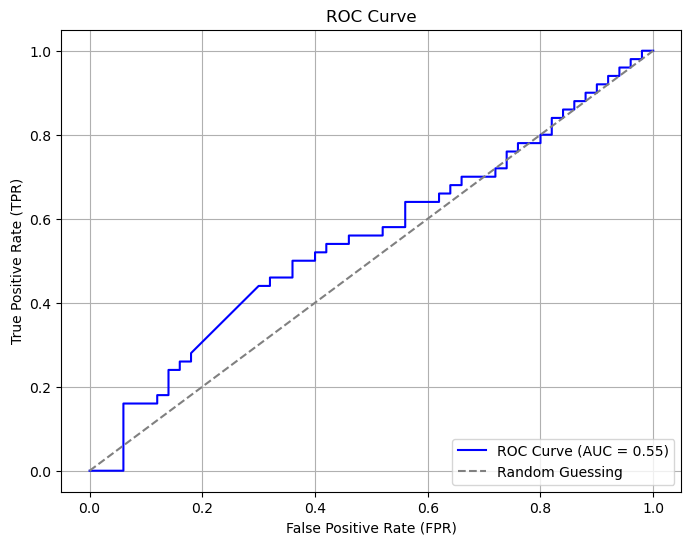

********Experiment of mfcc with 1 window(s) with Extractor over! ********
********Experiment of mfcc with 2 window(s) not with Extractor ********
The avg_acc of mfcc: 57.50%
The avg_precision of mfcc: 0.71
The avg_recall of mfcc: 0.91
The avg_f1_score of mfcc: 0.64


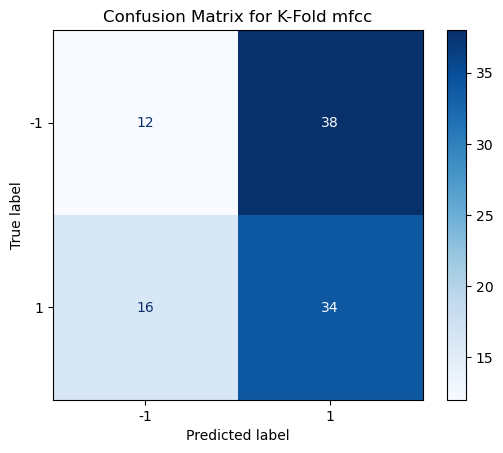

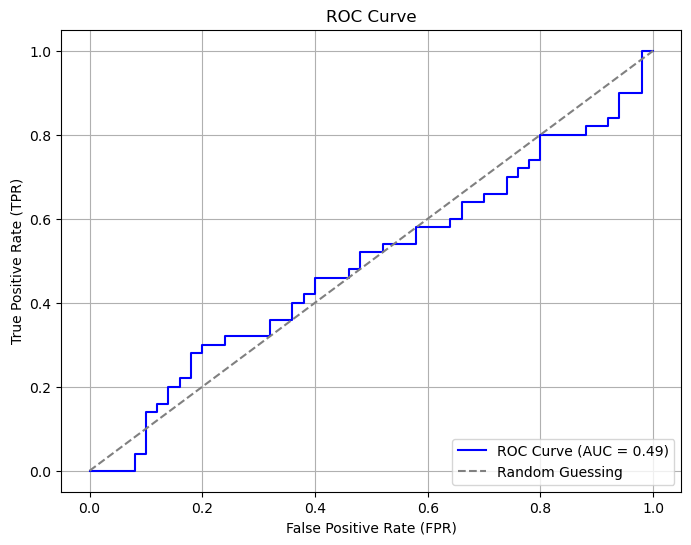

********Experiment of mfcc with 2 window(s) not with Extractor over! ********
********Experiment of mfcc with 2 window(s) with Extractor ********
The avg_acc of mfcc: 58.75%
The avg_precision of mfcc: 0.60
The avg_recall of mfcc: 0.72
The avg_f1_score of mfcc: 0.51


/home/james/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


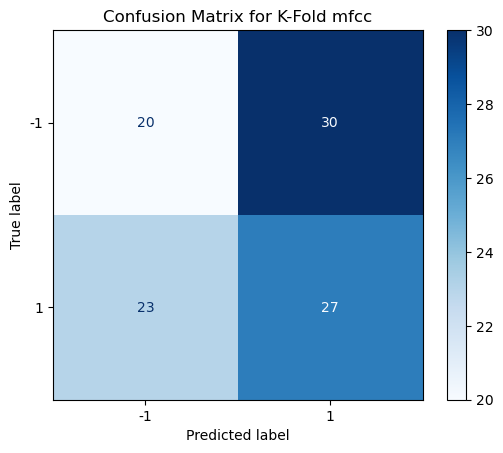

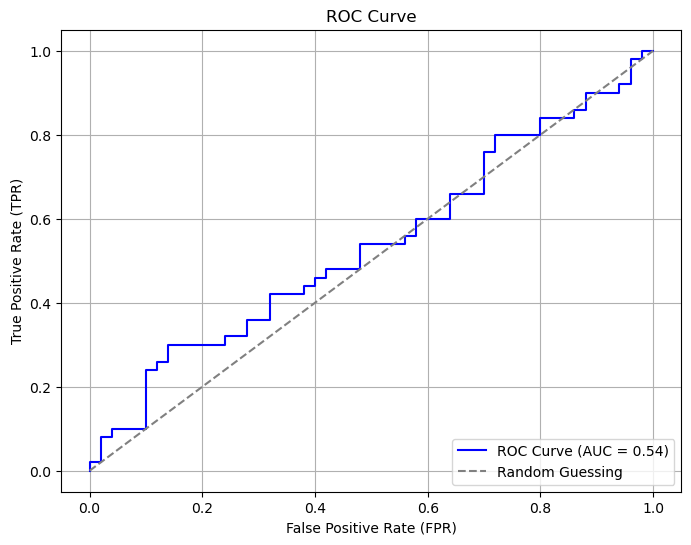

********Experiment of mfcc with 2 window(s) with Extractor over! ********
********Experiment of energy with 1 window(s) not with Extractor ********
The avg_acc of energy: 61.25%
The avg_precision of energy: 0.68
The avg_recall of energy: 0.76
The avg_f1_score of energy: 0.57


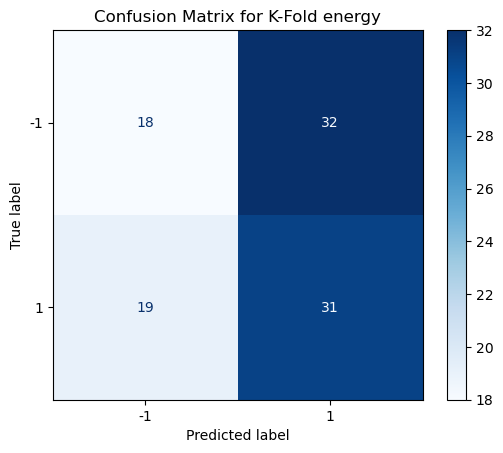

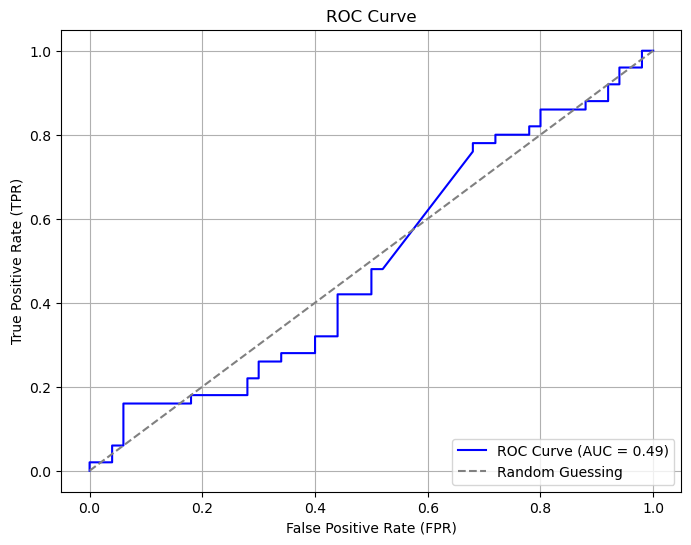

********Experiment of energy with 1 window(s) not with Extractor over! ********
********Experiment of energy with 1 window(s) with Extractor ********
The avg_acc of energy: 65.00%
The avg_precision of energy: 0.63
The avg_recall of energy: 0.71
The avg_f1_score of energy: 0.53


/home/james/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


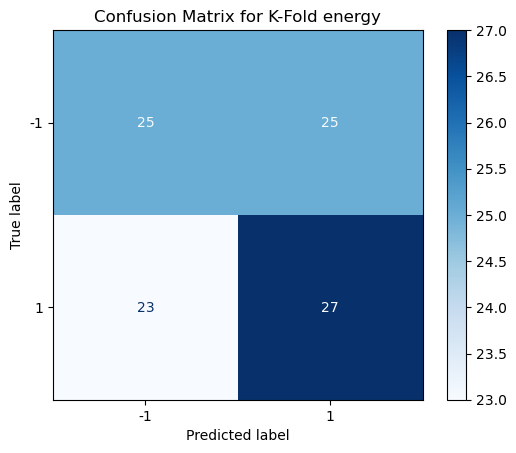

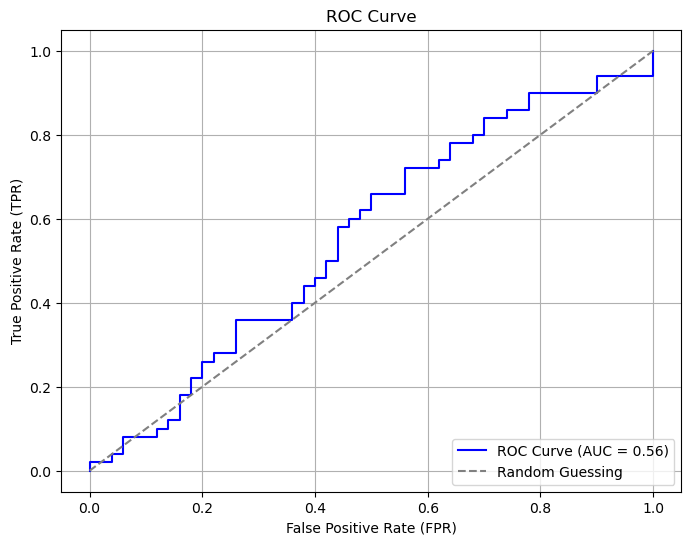

********Experiment of energy with 1 window(s) with Extractor over! ********
********Experiment of energy with 2 window(s) not with Extractor ********
The avg_acc of energy: 53.75%
The avg_precision of energy: 0.46
The avg_recall of energy: 0.97
The avg_f1_score of energy: 0.62


/home/james/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


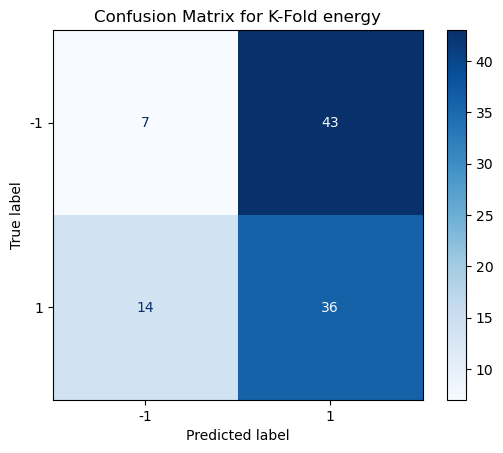

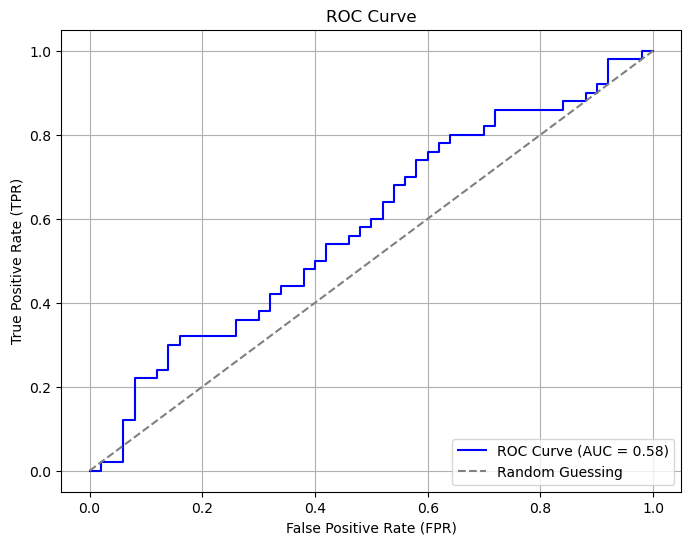

********Experiment of energy with 2 window(s) not with Extractor over! ********
********Experiment of energy with 2 window(s) with Extractor ********
The avg_acc of energy: 56.25%
The avg_precision of energy: 0.33
The avg_recall of energy: 0.55
The avg_f1_score of energy: 0.38


/home/james/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/james/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


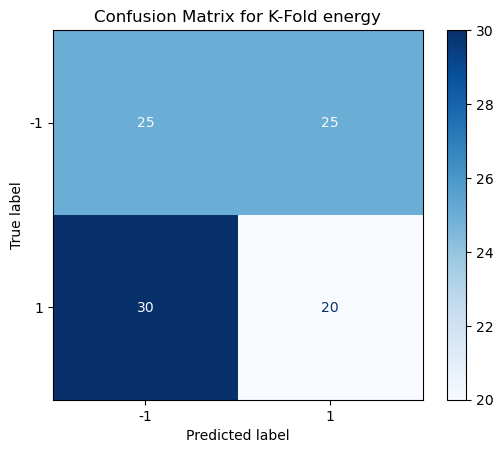

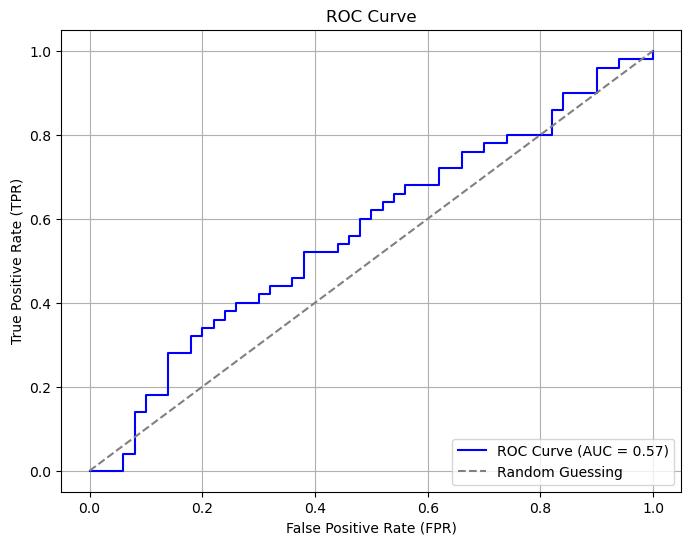

********Experiment of energy with 2 window(s) with Extractor over! ********


In [73]:
for sample_type in sample_types:
    for num in nums:
        for use_transformer in use_transformers:
            if not use_transformer:
                print('*' * 8 + f'Experiment of {sample_type} with {num} window(s) not with Extractor', '*' * 8)
            else:
                print('*' * 8 + f'Experiment of {sample_type} with {num} window(s) with Extractor', '*' * 8)
            
            if num == 1:
                with open('hyperparam_' + sample_type + '_' + str(num) + '_.txt', "r") as file:
                    lines = file.readlines()
                params = {}
                for line in lines:
                    key, value = line.strip().split(" = ")
                    params[key] = float(value)
                c = params.get("a")

                avg_acc, avg_precision, avg_recall, avg_f1 = 0., 0., 0., 0.
                label_all = []
                pred_all = []
                proba_all = []
                for k in range(fold_num):
                    valid_data, valid_label = total_data.pop(0), total_labels.pop(0)
                    train_data, train_label = np.concatenate(total_data, axis=0), np.concatenate(total_labels, axis=0)  # 80, 1, 4
                    if norm:
                        mean_train, std_train = train_data.mean(), train_data.std() 
                        norm_train_data = (train_data - mean_train) / std_train
                        norm_valid_data = (valid_data - mean_train) / std_train
                    elif not norm:
                        norm_train_data = train_data
                        norm_valid_data = valid_data
            
                    if noise:
                        train_noise = np.random.randn(train_data.shape[0], train_data.shape[1], train_data.shape[2])
                        norm_noise_train_data = norm_train_data + train_noise
                    elif not noise:
                        norm_noise_train_data = norm_train_data
            
                    model = SVC(C=c, kernel='rbf', gamma='scale', probability=True)
                    model.fit(norm_noise_train_data[:, 0], train_label)
                        
                    y_v_p = model.predict(norm_valid_data[:, 0])
                    y_v_proba = model.predict_proba(norm_valid_data[:, 0]) 
            
                    label_all.extend(valid_label)
                    pred_all.extend(y_v_p)
                    proba_all.extend(y_v_proba[:, 0])   ###
            
                    avg_acc += accuracy_score(valid_label, y_v_p)
                    avg_precision += precision_score(valid_label, y_v_p, average='binary')
                    avg_recall += recall_score(valid_label, y_v_p, average='binary') 
                    avg_f1 += f1_score(valid_label, y_v_p, average='binary')
            
                    total_data.append(valid_data)
                    total_labels.append(valid_label)
            
                print(f'The avg_acc of {sample_type}: {(avg_acc / 4 * 100):.2f}%')
                print(f'The avg_precision of {sample_type}: {(avg_precision / 4):.2f}')
                print(f'The avg_recall of {sample_type}: {(avg_recall / 4):.2f}')
                print(f'The avg_f1_score of {sample_type}: {(avg_f1 / 4):.2f}')
                conf_matrix = confusion_matrix(label_all, pred_all)
                disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique([-1, 1]))
                disp.plot(cmap="Blues")
                disp.ax_.set_title(f'Confusion Matrix for K-Fold {sample_type}')
            
                fpr, tpr, thresholds = roc_curve(label_all, proba_all)
                auc_score = roc_auc_score(label_all, proba_all)
                
                plt.figure(figsize=(8, 6))
                plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {auc_score:.2f})")
                plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label="Random Guessing")
                plt.title("ROC Curve")
                plt.xlabel("False Positive Rate (FPR)")
                plt.ylabel("True Positive Rate (TPR)")
                plt.legend(loc="lower right")
                plt.grid()    
                plt.show()
                
            elif num == 2:
                with open('hyperparam_' + sample_type + '_' + str(num) + '_.txt', "r") as file:
                    lines = file.readlines()
                params = {}
                
                for line in lines:
                    key, value = line.strip().split(" = ")
                    params[key] = float(value)
                
                c1 = params.get("a")
                c2 = params.get("b")

                avg_acc, avg_precision, avg_recall, avg_f1 = 0., 0., 0., 0.
                label_all = []
                pred_all = []
                proba_all = []
                for k in range(fold_num):
                    valid_data, valid_label = total_data.pop(0), total_labels.pop(0)
                    train_data, train_label = np.concatenate(total_data, axis=0), np.concatenate(total_labels, axis=0)  # 80, 2, 4
                    
                    if norm:
                        mean_train, std_train = train_data.mean(), train_data.std() 
                        norm_train_data = (train_data - mean_train) / std_train
                        norm_valid_data = (valid_data - mean_train) / std_train
                    elif not norm:
                        norm_train_data, norm_valid_data = train_data, valid_data
                
                    if noise:
                        train_noise = np.random.randn(train_data.shape[0], train_data.shape[1], train_data.shape[2])
                        norm_noise_train_data = norm_train_data + train_noise
                    elif not noise:
                        norm_noise_train_data = norm_train_data
                
                    model_1 = SVC(C=c1, kernel='rbf', gamma='scale', probability=True)
                    model_2 = SVC(C=c2, kernel='rbf', gamma='scale', probability=True)
                    
                    model_1.fit(norm_noise_train_data[:, 0], train_label)
                    model_2.fit(norm_noise_train_data[:, 1], train_label)
                    
                    y_p_1 = model_1.predict_proba(norm_noise_train_data[:, 0])
                    y_p_2 = model_2.predict_proba(norm_noise_train_data[:, 1])
                    x_3 = np.stack((y_p_1[:, 1], y_p_2[:, 1]), axis=-1)
                
                    model_3 = LogisticRegression()
                    model_3.fit(x_3, train_label)
                    
                    y_p_3 = model_3.predict(x_3)
                
                    y_v_p_1 = model_1.predict_proba(norm_valid_data[:, 0])
                    y_v_p_2 = model_2.predict_proba(norm_valid_data[:, 1])
                    x_v_3 = np.stack((y_v_p_1[:, 1], y_v_p_2[:, 1]), axis=-1)
                    y_v_p_3 = model_3.predict(x_v_3)
                    y_v_p_3_p = model_3.predict_proba(x_v_3)
                    label_all.extend(valid_label)
                    pred_all.extend(y_v_p_3)
                    proba_all.extend(y_v_p_3_p[:, 0])  ####
                    
                    avg_acc += accuracy_score(valid_label, y_v_p_3)
                    avg_precision += precision_score(valid_label, y_v_p_3, average='binary')
                    avg_recall += recall_score(valid_label, y_v_p_3, average='binary') 
                    avg_f1 += f1_score(valid_label, y_v_p_3, average='binary')
                    
                    total_data.append(valid_data)
                    total_labels.append(valid_label)
                    
                print(f'The avg_acc of {sample_type}: {(avg_acc / 4 * 100):.2f}%')
                print(f'The avg_precision of {sample_type}: {(avg_precision / 4):.2f}')
                print(f'The avg_recall of {sample_type}: {(avg_recall / 4):.2f}')
                print(f'The avg_f1_score of {sample_type}: {(avg_f1 / 4):.2f}')
                conf_matrix = confusion_matrix(label_all, pred_all)
                disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique([-1, 1]))
                disp.plot(cmap="Blues")
                disp.ax_.set_title(f'Confusion Matrix for K-Fold {sample_type}')
                
                fpr, tpr, thresholds = roc_curve(label_all, proba_all)
                auc_score = roc_auc_score(label_all, proba_all)
                
                plt.figure(figsize=(8, 6))
                plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {auc_score:.2f})")
                plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label="Random Guessing")
                plt.title("ROC Curve")
                plt.xlabel("False Positive Rate (FPR)")
                plt.ylabel("True Positive Rate (TPR)")
                plt.legend(loc="lower right")
                plt.grid()    
                plt.show()
            if not use_transformer:
                print('*' * 8 + f'Experiment of {sample_type} with {num} window(s) not with Extractor over!', '*' * 8)
            else:
                print('*' * 8 + f'Experiment of {sample_type} with {num} window(s) with Extractor over!', '*' * 8)

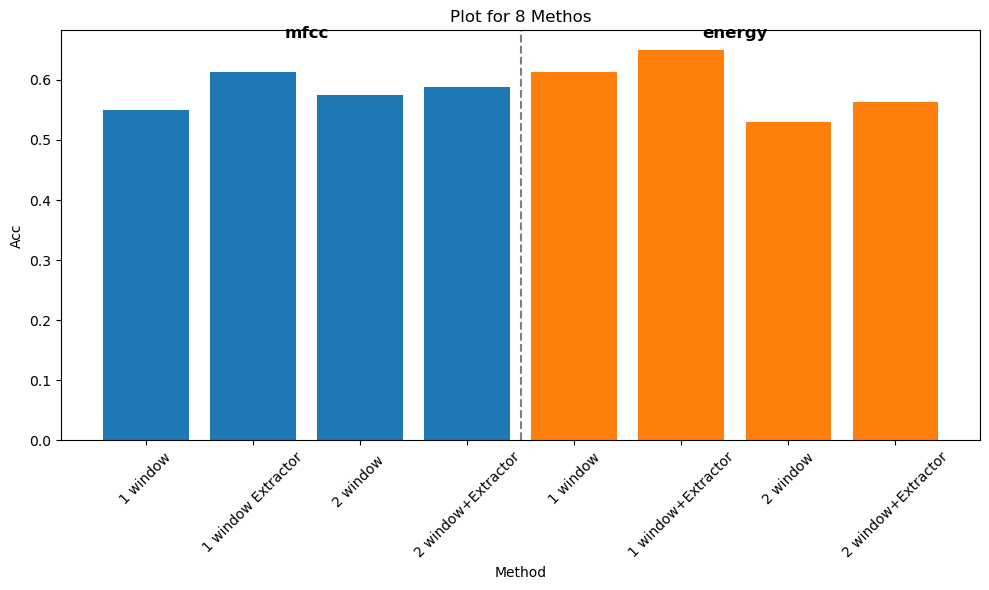

In [78]:
y_values = [0.55, 0.6125, 0.575, 0.5875, 0.6125, 0.65, 0.53, 0.5625]
x_labels = ['1 window', '1 window Extractor', '2 window ', '2 window+Extractor', '1 window', '1 window+Extractor', '2 window', '2 window+Extractor']
categories = ['mfcc', 'energy']

plt.figure(figsize=(10, 6))

x_positions = range(len(y_values))
plt.bar(x_positions, y_values, color=['#1f77b4'] * 4 + ['#ff7f0e'] * 4)

plt.xticks(x_positions, x_labels, rotation=45)
plt.xlabel('Method')
plt.ylabel('Acc')
plt.title('Plot for 8 Methos')

plt.text(1.5, max(y_values) + 0.02, 'mfcc', ha='center', fontsize=12, fontweight='bold')
plt.text(5.5, max(y_values) + 0.02, 'energy', ha='center', fontsize=12, fontweight='bold')
plt.axvline(x=3.5, color='gray', linestyle='--')

plt.tight_layout()
plt.show()

# 7 Conclusions
&nbsp;&nbsp;&nbsp;&nbsp;In the case of 1 window, the correct rate is higher, especially in the Energy feature, and the performance of 1 window and 1 window + Extractor is significantly better than that of 2 windows.
In the case of 2 window, the correct rate decreases, especially in the Energy feature, indicating that increasing the number of windows does not bring better performance.<br>
&nbsp;&nbsp;&nbsp;&nbsp;In MFCC and Energy, using Extractor (i.e., 1 window + Extractor and 2 window + Extractor) has a certain effect on the correct rate.
In MFCC, 1 window + Extractor is slightly higher than 1 window, and in Energy, 1 window + Extractor is significantly higher than 1 window, which is the most significant effect. However, when the number of windows is increased to 2 windows, even with Extractor (2 window + Extractor), the improvement in the correct rate is limited, and there is no significant advantage over 2 windows.<br>
&nbsp;&nbsp;&nbsp;&nbsp;The overall performance of the Energy feature is better than the MFCC feature.
Energy achieves the highest correct rate in 1 window and 1 window + Extractor, especially 1 window + Extractor.
The correct rate of MFCC is relatively stable, but slightly lower than Energy.
The Energy feature is more suitable for combining with 1 window, and the performance improvement is more obvious when using Extractor.<br>
&nbsp;&nbsp;&nbsp;&nbsp;1 window is better than 2 window, especially for Energy feature.
Using Extractor can improve the correct rate, especially for the Energy feature, and the overall performance of the Energy feature is better than that of the MFCC feature, especially when combined with 1 window and Extractor.<br>
&nbsp;&nbsp;&nbsp;&nbsp;The use of a single window is preferable to that of two windows, particularly in the context of energy-related features. The incorporation of an extractor enhances the accuracy of the results, particularly in the domain of energy-related features. Furthermore, the overall performance of energy-related features is superior to that of MFCC features, particularly when a combination of a single window and an extractor is employed. It is anticipated that with the advent of more extensive audio data and enhanced computing capabilities, we will be able to delve deeper into the investigation of the optimal number of sample segments and the most effective methods for audio feature extraction.<br>